In [1]:
%matplotlib inline

# Essentials: Data Cleansing and ETL
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.legend_handler import HandlerLine2D

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc # good for evaluation of binary classification problems
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('nflData.csv', sep=",")

C:\Users\RICHARDSONLG20\AppData\Local\Temp\ipykernel_27564\104963401.py:1: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('nflData.csv', sep=",")


In [3]:
print("Rows: ",len(df))

Rows:  449371


In [8]:
# take the dataframe for plays above and define particular columns we want
play_attr = ['game_id','qtr','game_seconds_remaining','yardline_100','ydstogo','drive','down','play_type','goal_to_go',
             'posteam','defteam','posteam_score', 'defteam_score', 'score_differential','posteam_timeouts_remaining','no_score_prob',
             'opp_fg_prob','opp_safety_prob','home_team', 'rushing_mean', 'passing_mean']
plays = df[play_attr]

df = df[(df.play_type == "run")|(df.play_type=="pass")]

In [7]:
plays['play_type'] = plays.apply(lambda x: 1 if x.play_type == "pass" else 0, axis=1)

In [ ]:
# drop unneeded columns to begin to de-clutter the set
plays = plays[plays.down != 0]
plays = plays.drop(columns=['home_team'])

plays.head(5)

game_id  qtr  game_seconds_remaining  yardline_100  ydstogo  drive  \
1  2009091000    1                    3593            58       10      1   
2  2009091000    1                    3556            53        5      1   
3  2009091000    1                    3515            56        8      1   
4  2009091000    1                    3507            56        8      1   
5  2009091000    1                    3496            98       10      2   

   down  play_type  goal_to_go posteam  ... score_differential  \
1     1          1           0     PIT  ...                  0   
2     2          0           0     PIT  ...                  0   
3     3          1           0     PIT  ...                  0   
4     4          0           0     PIT  ...                  0   
5     1          0           0     TEN  ...                  0   

   posteam_timeouts_remaining  no_score_prob  opp_fg_prob  opp_safety_prob  \
1                         3.0              0            3                2   
2                         3.0              0            2                2   
3                         3.0              0            3                3   
4                         3.0              1            4                3   
5                         3.0              1            4                4   

   rushing_mean  passing_mean  Home  UpByTwoScoresBool  UpByThreeScoresBool  
1             3             5     1                  0                    0  
2             3             5     1                  0                    0  
3             3             5     1                  0                    0  
4             3             5     1                  0                    0  
5            26            35     0                  0                    0  

[5 rows x 23 columns]

In [13]:
plays.dropna(inplace=True)

In [14]:
plays = plays.reset_index()

# Define our prediction data
plays_predictors = [ 'UpByTwoScoresBool','UpByTwoScoresBool',
'game_id','qtr','game_seconds_remaining','yardline_100',
'ydstogo','drive','down', 'goal_to_go','posteam_score', 'defteam_score', 
'score_differential','posteam_timeouts_remaining',
'no_score_prob','opp_fg_prob','opp_safety_prob', 'rushing_mean', 'passing_mean', 'Home',]

X = plays[plays_predictors]

# Define the prediction target: PlayType
y = plays.play_type

In [15]:
# Split our data into training and test data for both our target and prediction data sets
# random state = 0 means we get same result everytime if we want to change later
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)

In [16]:
# print(np.any(np.isnan(train_x)))
# print(np.all(np.isfinite(train_x)))

# Decision Tree Classifier
desc_tree = DecisionTreeClassifier()
desc_tree.fit(train_X, train_y)

dt_predictions = desc_tree.predict(val_X)

print(dt_predictions[:10])

false_positive_rate, true_positive_rate, thresholds = roc_curve(val_y, dt_predictions)
dt_roc_auc = auc(false_positive_rate, true_positive_rate)

[0 1 0 0 1 1 1 1 0 0]


In [17]:
print(dt_roc_auc)

0.6304312766772155


<AxesSubplot:xlabel='feature'>

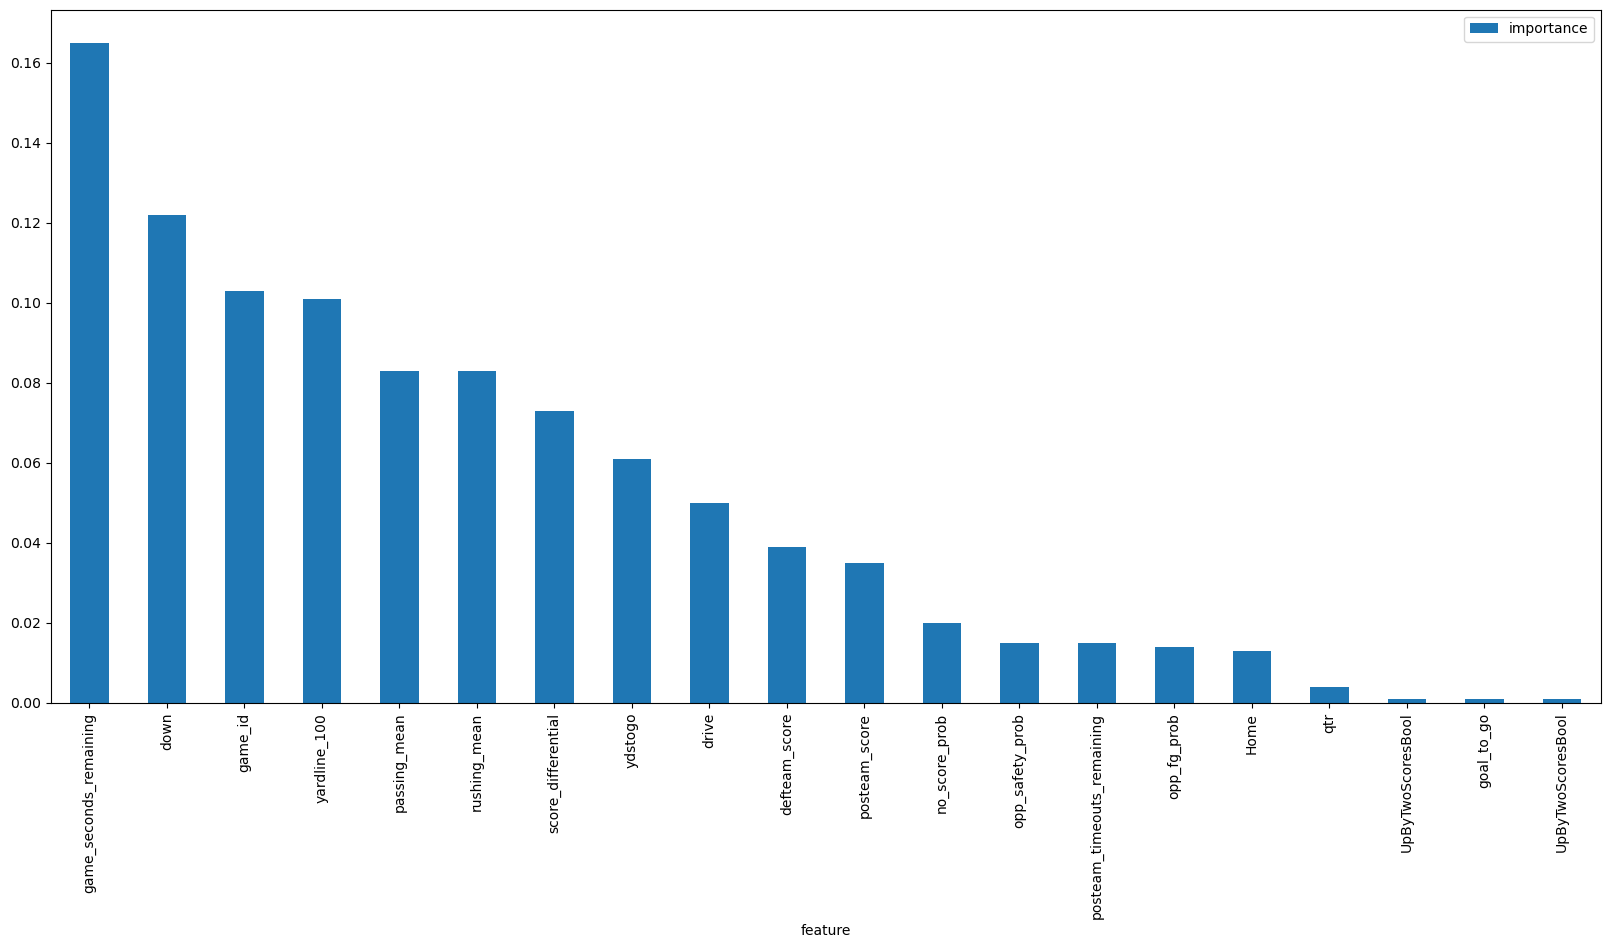

In [18]:
importances = pd.DataFrame({'feature':train_X.columns,'importance':np.round(desc_tree.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar(figsize=(20,9),rot=90)

In [19]:
def acc(predicted, actual):
    correct = 0

    for i in range(len(actual)-1):
        if (predicted[i] == actual.iloc[i]):
            correct+=1
    print(f"Accuracy: {(correct/len(actual))*100}%")
    
acc(dt_predictions, val_y)

Accuracy: 63.064661780456554%
